<a href="https://colab.research.google.com/github/sinaebrahimi/ml-7072cem/blob/master/Classifying%20Network%20Slices%20Based%20on%20User%20Requirements/prediction-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
import pandas as pd
import numpy as np

# df_train_cleaned = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/2024-01- 7072CEM (ML Module)/Project/slice_type_prediction/train_cleaned.csv')


# df_test_cleaned = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/2024-01- 7072CEM (ML Module)/Project/slice_type_prediction/test_cleaned.csv')


df = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/2024-01- 7072CEM (ML Module)/Project/slice_type_prediction/train_dataset.csv')
df.head(n=5)



,LTE/5g Category,Time,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR,AR/VR/Gaming,Healthcare,Industry 4.0,IoT Devices,Public Safety,Smart City & Home,Smart Transportation,Smartphone,slice Type
0,14,0,0.000001,10,1,0,0,1,0,0,0,0,1,0,0,0,3
1,18,20,0.001000,100,0,1,1,0,1,0,0,0,0,0,0,0,1
2,17,14,0.000001,300,0,1,0,1,0,0,0,0,0,0,0,1,1
3,3,17,0.010000,100,0,1,0,1,0,0,0,0,0,0,0,1,1
4,9,4,0.010000,50,1,0,0,1,0,0,0,0,0,1,0,0,2


We can use a function from this link to reduce memory usage of both datasets!

In [108]:
def reduce_mem_usage(train):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = train.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train.columns:
        col_type = train[col].dtype

        if col_type != object:
            c_min = train[col].min()
            c_max = train[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train[col] = train[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train[col] = train[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train[col] = train[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train[col] = train[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train[col] = train[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train[col] = train[col].astype(np.float32)
                else:
                    train[col] = train[col].astype(np.float64)
        else:
            train[col] = train[col].astype('object')

    end_mem = train.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train

df_cleaned = reduce_mem_usage(df)
df_cleaned.info()

Memory usage of dataframe is 4.10 MB
Memory usage after optimization is: 0.57 MB
Decreased by 86.0%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31583 entries, 0 to 31582
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LTE/5g Category       31583 non-null  int8   
 1   Time                  31583 non-null  int8   
 2   Packet Loss Rate      31583 non-null  float16
 3   Packet delay          31583 non-null  int16  
 4   IoT                   31583 non-null  int8   
 5   LTE/5G                31583 non-null  int8   
 6   GBR                   31583 non-null  int8   
 7   Non-GBR               31583 non-null  int8   
 8   AR/VR/Gaming          31583 non-null  int8   
 9   Healthcare            31583 non-null  int8   
 10  Industry 4.0          31583 non-null  int8   
 11  IoT Devices           31583 non-null  int8   
 12  Public Safety         31583 non-null  int8   
 13  Smart City & Home    

Now let's split the data and select the features.

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split

#X = df.drop(['slice Type'], axis=1)
X = df_cleaned[['LTE/5g Category', 'Time', 'Packet Loss Rate', 'Packet delay', 'Healthcare']]  # Features # The other features are dropped because they mmight not be available in real implementations
y = df_cleaned['slice Type']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=12)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(22108, 5)
(9475, 5)
(22108,)
(9475,)


Let's start with Decision Tree

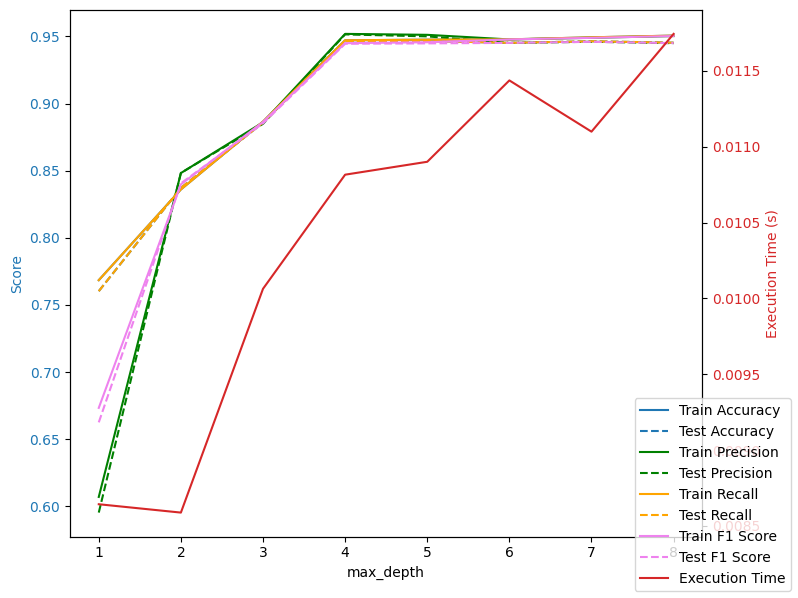

In [137]:
#@title Decision Tree (DT)

import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define the model
model = DecisionTreeClassifier()

# Define the hyperparameters to tune
params = range(1, 9) #max_depth

# Initialize lists to store results
train_accuracy_scores = []
test_accuracy_scores = []
train_precision_scores = []
test_precision_scores = []
train_recall_scores = []
test_recall_scores = []
train_f1_scores = []
test_f1_scores = []
exec_times = []

# Loop over each max_depth
for max_depth in params:
    # Start the timer
    start_time = time.time()

    # Create and fit the model
    model.set_params(max_depth=max_depth)
    model.fit(X_train, y_train)

    # Stop the timer
    end_time = time.time()

    # Calculate the execution time
    exec_time = end_time - start_time

    # Evaluate the model
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)

    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')

    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Append the results to the lists
    train_accuracy_scores.append(train_accuracy)
    test_accuracy_scores.append(test_accuracy)
    train_precision_scores.append(train_precision)
    test_precision_scores.append(test_precision)
    train_recall_scores.append(train_recall)
    test_recall_scores.append(test_recall)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    exec_times.append(exec_time)

# Plot the results
fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:blue'
ax1.set_xlabel('max_depth')
ax1.set_ylabel('Score', color=color)
ax1.plot(params, train_accuracy_scores, color=color, label='Train Accuracy')
ax1.plot(params, test_accuracy_scores, color=color, linestyle='dashed', label='Test Accuracy')
ax1.plot(params, train_precision_scores, color='green', label='Train Precision')
ax1.plot(params, test_precision_scores, color='green', linestyle='dashed', label='Test Precision')
ax1.plot(params, train_recall_scores, color='orange', label='Train Recall')
ax1.plot(params, test_recall_scores, color='orange', linestyle='dashed', label='Test Recall')
ax1.plot(params, train_f1_scores, color='violet', label='Train F1 Score')
ax1.plot(params, test_f1_scores, color='violet', linestyle='dashed', label='Test F1 Score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Execution Time (s)', color=color)
ax2.plot(params, exec_times, color=color, label='Execution Time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc="lower right")
plt.show()


So, we choose max_depth=4

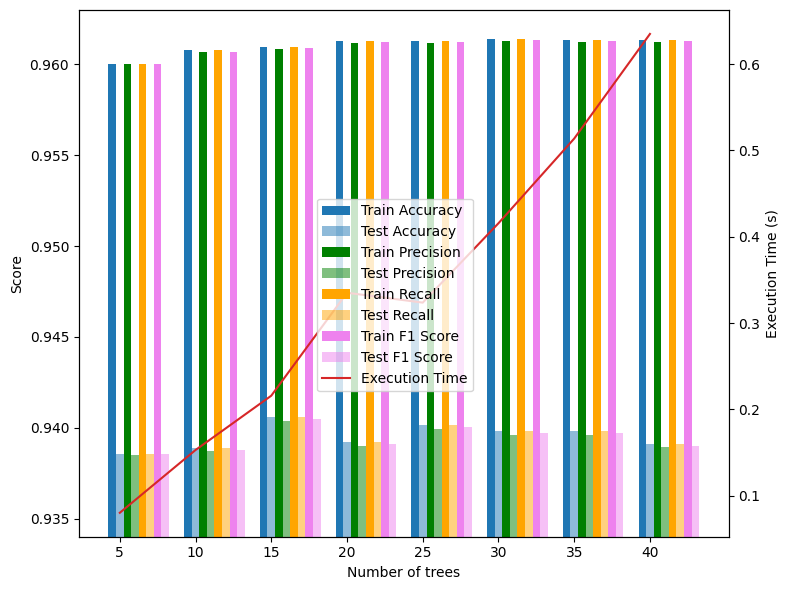

In [154]:
#@title Random Forest (RF)

import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


# Define the model
model = RandomForestClassifier()

# Define the hyperparameters to tune
params =  [5, 10, 15, 20, 25, 30, 35, 40] #n_estimators
#'max_depth': [None, 10, 20, 30, 40, 50]}

# Initialize lists to store results
train_accuracy_scores = []
test_accuracy_scores = []
train_precision_scores = []
test_precision_scores = []
train_recall_scores = []
test_recall_scores = []
train_f1_scores = []
test_f1_scores = []
exec_times = []

# Loop over each max_depth
for n_estimators in params:
    # Start the timer
    start_time = time.time()

    # Create and fit the model
    model.set_params(n_estimators=n_estimators)
    model.fit(X_train, y_train)

    # Stop the timer
    end_time = time.time()

    # Calculate the execution time
    exec_time = end_time - start_time

    # Evaluate the model
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)

    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')

    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Append the results to the lists
    train_accuracy_scores.append(train_accuracy)
    test_accuracy_scores.append(test_accuracy)
    train_precision_scores.append(train_precision)
    test_precision_scores.append(test_precision)
    train_recall_scores.append(train_recall)
    test_recall_scores.append(test_recall)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    exec_times.append(exec_time)

# Plot the results
fig, ax1 = plt.subplots(figsize=(8, 6))

# Define the positions for the bars
bar_width = 0.1
positions = np.arange(len(params))

# Plot the scores as bars
ax1.bar(positions - bar_width, train_accuracy_scores, width=bar_width, color='tab:blue', label='Train Accuracy')
ax1.bar(positions, test_accuracy_scores, width=bar_width, color='tab:blue', alpha=0.5, label='Test Accuracy')
ax1.bar(positions + bar_width, train_precision_scores, width=bar_width, color='green', label='Train Precision')
ax1.bar(positions + 2*bar_width, test_precision_scores, width=bar_width, color='green', alpha=0.5, label='Test Precision')
ax1.bar(positions + 3*bar_width, train_recall_scores, width=bar_width, color='orange', label='Train Recall')
ax1.bar(positions + 4*bar_width, test_recall_scores, width=bar_width, color='orange', alpha=0.5, label='Test Recall')
ax1.bar(positions + 5*bar_width, train_f1_scores, width=bar_width, color='violet', label='Train F1 Score')
ax1.bar(positions + 6*bar_width, test_f1_scores, width=bar_width, color='violet', alpha=0.5, label='Test F1 Score')

# Set the x-axis labels and title
ax1.set_xticks(positions)
ax1.set_xticklabels(params)
ax1.set_xlabel('Number of trees')
ax1.set_ylabel('Score')
ax1.set_ylim([0.934, 0.963])  # Limit the y-axis for score

# Create the second y-axis for execution time
ax2 = ax1.twinx()
ax2.plot(positions, exec_times, color='tab:red', label='Execution Time')
ax2.set_ylabel('Execution Time (s)')

# Add a legend and show the plot
fig.tight_layout()
fig.legend(loc="center")
plt.show()

So, we choose n_estimators=15 (number of trees).

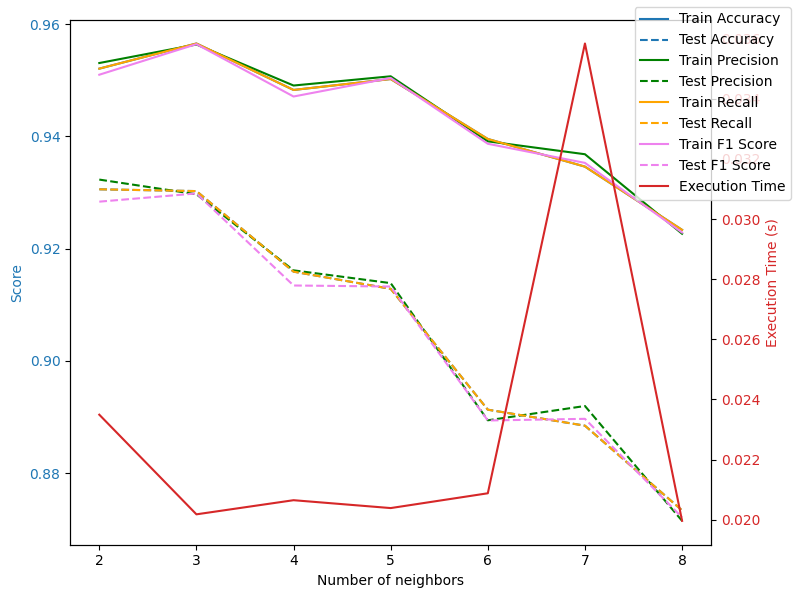

In [161]:
#@title KNN

import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Define the model
model = KNeighborsClassifier()

# Define the hyperparameters to tune
params =  range(2,9) # [1,2,3,4, 5, 7, 9] #n_neighbors
#'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']


# Initialize lists to store results
train_accuracy_scores = []
test_accuracy_scores = []
train_precision_scores = []
test_precision_scores = []
train_recall_scores = []
test_recall_scores = []
train_f1_scores = []
test_f1_scores = []
exec_times = []

# Loop over each max_depth
for n_neighbors in params:
    # Start the timer
    start_time = time.time()

    # Create and fit the model
    model.set_params(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

    # Stop the timer
    end_time = time.time()

    # Calculate the execution time
    exec_time = end_time - start_time

    # Evaluate the model
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)

    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')

    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Append the results to the lists
    train_accuracy_scores.append(train_accuracy)
    test_accuracy_scores.append(test_accuracy)
    train_precision_scores.append(train_precision)
    test_precision_scores.append(test_precision)
    train_recall_scores.append(train_recall)
    test_recall_scores.append(test_recall)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    exec_times.append(exec_time)

# Plot the results
fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of neighbors')
ax1.set_ylabel('Score', color=color)
ax1.plot(params, train_accuracy_scores, color=color, label='Train Accuracy')
ax1.plot(params, test_accuracy_scores, color=color, linestyle='dashed', label='Test Accuracy')
ax1.plot(params, train_precision_scores, color='green', label='Train Precision')
ax1.plot(params, test_precision_scores, color='green', linestyle='dashed', label='Test Precision')
ax1.plot(params, train_recall_scores, color='orange', label='Train Recall')
ax1.plot(params, test_recall_scores, color='orange', linestyle='dashed', label='Test Recall')
ax1.plot(params, train_f1_scores, color='violet', label='Train F1 Score')
ax1.plot(params, test_f1_scores, color='violet', linestyle='dashed', label='Test F1 Score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Execution Time (s)', color=color)
ax2.plot(params, exec_times, color=color, label='Execution Time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc="upper right")
plt.show()

So, the best trade-off is found for n_neighbors=3!

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

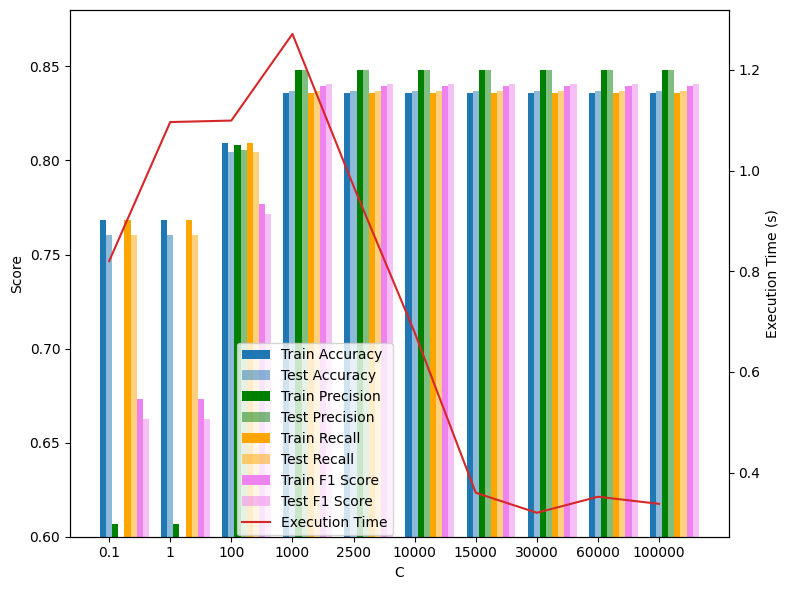

In [188]:
#@title KNN

import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Define the model
model = LogisticRegression(multi_class='ovr')

# Define the hyperparameters to tune
params =  [0.1, 1, 100, 1000, 2500, 10000, 15000, 30000, 60000, 100000] # C
#params =  [0.01, 0.1, 1, 10, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]


# Initialize lists to store results
train_accuracy_scores = []
test_accuracy_scores = []
train_precision_scores = []
test_precision_scores = []
train_recall_scores = []
test_recall_scores = []
train_f1_scores = []
test_f1_scores = []
exec_times = []

# Loop over each max_depth
for c in params:
    # Start the timer
    start_time = time.time()

    # Create and fit the model
    model.set_params(C=c)
    model.fit(X_train, y_train)

    # Stop the timer
    end_time = time.time()

    # Calculate the execution time
    exec_time = end_time - start_time

    # Evaluate the model
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)

    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')

    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Append the results to the lists
    train_accuracy_scores.append(train_accuracy)
    test_accuracy_scores.append(test_accuracy)
    train_precision_scores.append(train_precision)
    test_precision_scores.append(test_precision)
    train_recall_scores.append(train_recall)
    test_recall_scores.append(test_recall)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    exec_times.append(exec_time)

# Plot the results
fig, ax1 = plt.subplots(figsize=(8, 6))

# Define the positions for the bars
bar_width = 0.1
positions = np.arange(len(params))

# Plot the scores as bars
ax1.bar(positions - bar_width, train_accuracy_scores, width=bar_width, color='tab:blue', label='Train Accuracy')
ax1.bar(positions, test_accuracy_scores, width=bar_width, color='tab:blue', alpha=0.5, label='Test Accuracy')
ax1.bar(positions + bar_width, train_precision_scores, width=bar_width, color='green', label='Train Precision')
ax1.bar(positions + 2*bar_width, test_precision_scores, width=bar_width, color='green', alpha=0.5, label='Test Precision')
ax1.bar(positions + 3*bar_width, train_recall_scores, width=bar_width, color='orange', label='Train Recall')
ax1.bar(positions + 4*bar_width, test_recall_scores, width=bar_width, color='orange', alpha=0.5, label='Test Recall')
ax1.bar(positions + 5*bar_width, train_f1_scores, width=bar_width, color='violet', label='Train F1 Score')
ax1.bar(positions + 6*bar_width, test_f1_scores, width=bar_width, color='violet', alpha=0.5, label='Test F1 Score')

# Set the x-axis labels and title
ax1.set_xticks(positions)
ax1.set_xticklabels(params)
ax1.set_xlabel('C')
ax1.set_ylabel('Score')
ax1.set_ylim([0.6, 0.88])  # Limit the y-axis for score

# Create the second y-axis for execution time
ax2 = ax1.twinx()
ax2.plot(positions, exec_times, color='tab:red', label='Execution Time')
ax2.set_ylabel('Execution Time (s)')

# Add a legend and show the plot
fig.tight_layout()
fig.legend(loc="center", bbox_to_anchor=(0.4, 0.26))
# fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.96))
plt.show()


We chose 15000 for the best trade-off.

--------------------------------


Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 50}
Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

           1       0.95      0.95      0.95      4238
           2       0.87      0.88      0.87      1792
           3       1.00      1.00      1.00      1866

    accuracy                           0.94      7896
   macro avg       0.94      0.94      0.94      7896
weighted avg       0.94      0.94      0.94      7896



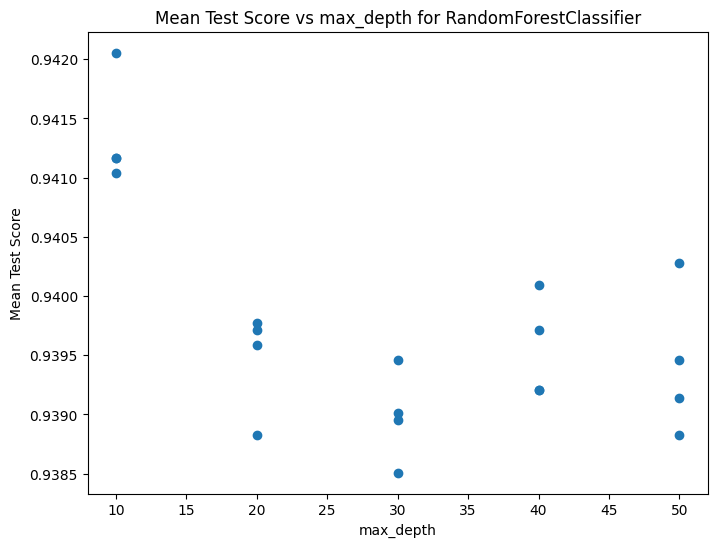

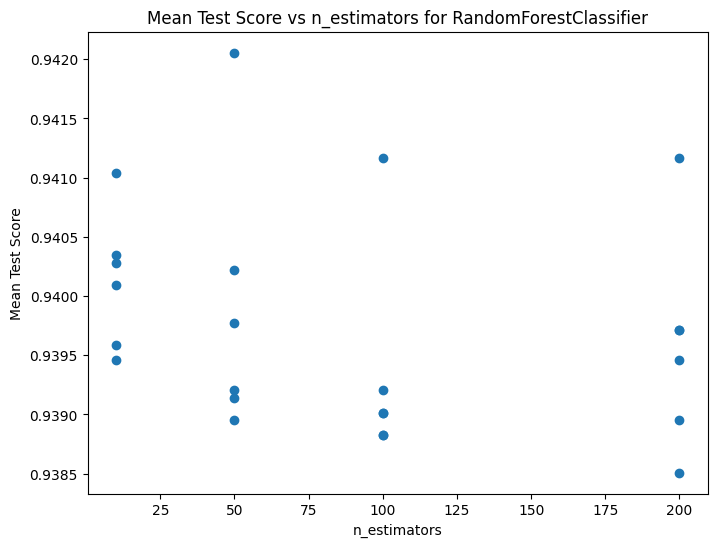

KeyboardInterrupt: 

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have X_train, X_test, y_train, y_test

classifiers = {
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC()
}

# Define the hyperparameters to tune for each classifier
hyperparameters = {
    'RandomForestClassifier': {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 10, 20, 30, 40, 50]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 11, 19], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'DecisionTreeClassifier': {'max_depth': np.arange(1, 15)},
    'LogisticRegression': {'C': np.logspace(-3,3,7), 'penalty': ["l1","l2"]},
    'SVC': {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
}

for name, classifier in classifiers.items():
    grid = GridSearchCV(classifier, hyperparameters[name], cv=5)
    grid.fit(X_train, y_train)

    print(f"Best parameters for {name}: {grid.best_params_}")

    y_pred = grid.predict(X_test)

    print(f"Classification report for {name}:")
    print(classification_report(y_test, y_pred))

    # Assuming you have a function plot_metrics to plot the metrics
    plot_metrics(grid.cv_results_, name)



----------------
Training and predicting with RF...
RF saved as RF_classifier.pkl
              precision    recall  f1-score   support

           1       0.94      0.95      0.95      4195
           2       0.88      0.87      0.88      1855
           3       1.00      1.00      1.00      1846

    accuracy                           0.94      7896
   macro avg       0.94      0.94      0.94      7896
weighted avg       0.94      0.94      0.94      7896


----------------
Training and predicting with SVM...
SVM saved as SVM_classifier.pkl
              precision    recall  f1-score   support

           1       1.00      0.70      0.82      4195
           2       0.59      1.00      0.74      1855
           3       1.00      1.00      1.00      1846

    accuracy                           0.84      7896
   macro avg       0.86      0.90      0.85      7896
weighted avg       0.90      0.84      0.84      7896


----------------
Training and predicting with KNN...
KNN saved as KN

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LC saved as LC_classifier.pkl
              precision    recall  f1-score   support

           1       0.71      0.98      0.82      4195
           2       0.69      0.10      0.18      1855
           3       1.00      1.00      1.00      1846

    accuracy                           0.78      7896
   macro avg       0.80      0.69      0.67      7896
weighted avg       0.77      0.78      0.71      7896



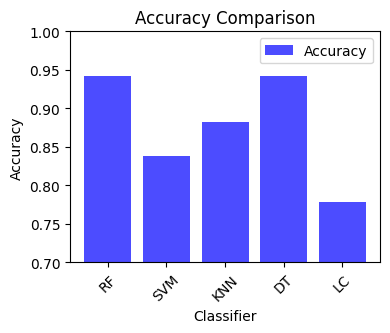

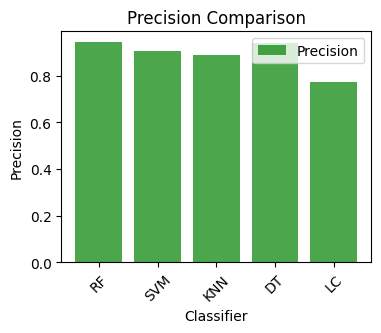

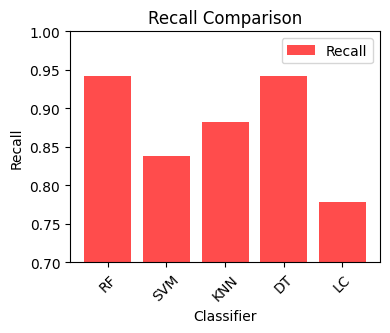

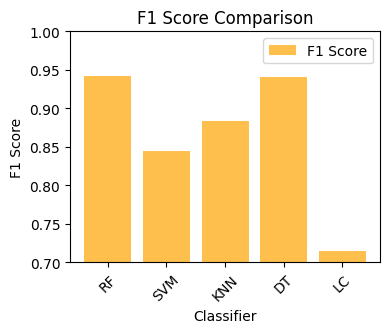

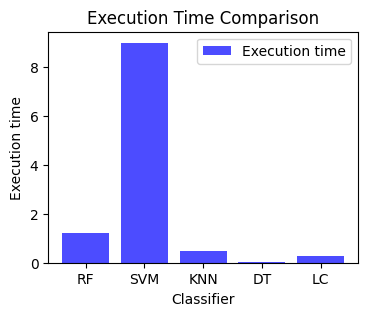

In [104]:
classifiers = {
    'RF': RandomForestClassifier(), #random forest
    'SVM': SVC(kernel='rbf'), #Support vector machine
    'KNN': KNeighborsClassifier(), #K-Nearest Neighbor
    'DT': DecisionTreeClassifier(), #max_depth=3 #decision tree
    'LC': LogisticRegression() #linear classifier
}


# Create dictionaries to store evaluation metrics
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}
exec_times = {}

# Initialize a dictionary to store trained classifiers
trained_classifiers = {}

# Train classifiers on the training data and evaluate their performance on the test data
for name, classifier in classifiers.items():
    print(f"\n----------------\nTraining and predicting with {name}...")
    start_time = time.time()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_valid)
    end_time = time.time()
    exec_times[name] = end_time - start_time
    accuracy_scores[name] = accuracy_score(y_valid, y_pred)
    precision_scores[name] = precision_score(y_valid, y_pred, average='weighted')
    recall_scores[name] = recall_score(y_valid, y_pred, average='weighted')
    f1_scores[name] = f1_score(y_valid, y_pred, average='weighted')

    ###
    # Save the trained classifier to a file
    filename = f'{name}_classifier.pkl'
    file_path = f'/content/drive/MyDrive/2024-01- 7072CEM (ML Module)/Project/slice_type_prediction/' + filename
    joblib.dump(classifier, file_path)
    print(f"{name} saved as {filename}")
    print(classification_report(y_valid, y_pred))

    # Store the trained classifier in the dictionary
    trained_classifiers[name] = classifier

# Plot evaluation metrics for each classifier
plt.figure(figsize=(4, 3))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='blue', alpha=0.7, label='Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.ylim(0.7,1)
plt.show()

###############################
plt.figure(figsize=(4, 3))
plt.bar(precision_scores.keys(), precision_scores.values(), color='green', alpha=0.7, label='Precision')
plt.xlabel('Classifier')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()

################################
plt.figure(figsize=(4, 3))
plt.bar(recall_scores.keys(), recall_scores.values(), color='red', alpha=0.7, label='Recall')
plt.xlabel('Classifier')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.ylim(0.7,1)
plt.show()

################################
plt.figure(figsize=(4, 3))
plt.bar(f1_scores.keys(), f1_scores.values(), color='orange', alpha=0.7, label='F1 Score')
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.ylim(0.7,1)
plt.show()

#################################
plt.figure(figsize=(4, 3))
plt.bar(exec_times.keys(), exec_times.values(), color='blue', alpha=0.7, label='Execution time')
plt.xlabel('Classifier')
plt.ylabel('Execution time')
plt.title('Execution Time Comparison')
plt.legend()
#plt.xticks(rotation=45)
#plt.ylim(0.7,1)
plt.show()

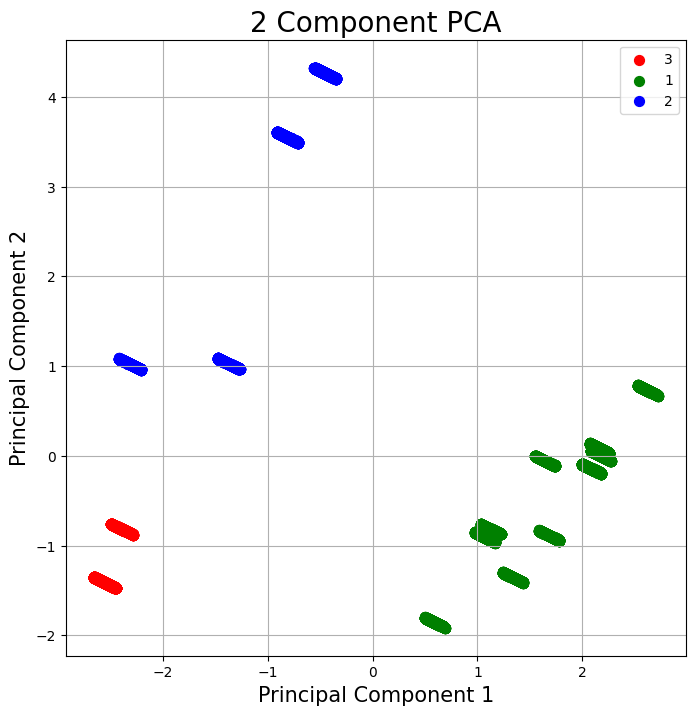

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt


# Standardize the features to have mean=0 and variance=1
features = df.columns[:-1]  # Exclude the target variable
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)  # Change the number of components you want to keep
principalComponents = pca.fit_transform(x)

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# Concatenate the target variable
df_pca = pd.concat([df_pca, df[['slice Type']]], axis=1)

#####################
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('2 Component PCA', fontsize=20)

targets = df['slice Type'].unique()
colors = ['r', 'g', 'b']  # Add more colors if you have more than 3 classes

for target, color in zip(targets, colors):
    indicesToKeep = df_pca['slice Type'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC1'], df_pca.loc[indicesToKeep, 'PC2'], c=color, s=50)

ax.legend(targets)
ax.grid()
plt.show()



----------------
Training and predicting with RF...
RF saved as RF_classifier.pkl
              precision    recall  f1-score   support

           1       0.95      0.95      0.95      4195
           2       0.88      0.88      0.88      1855
           3       1.00      1.00      1.00      1846

    accuracy                           0.94      7896
   macro avg       0.94      0.94      0.94      7896
weighted avg       0.94      0.94      0.94      7896


----------------
Training and predicting with SVM...
SVM saved as SVM_classifier.pkl
              precision    recall  f1-score   support

           1       1.00      0.70      0.82      4195
           2       0.59      1.00      0.74      1855
           3       1.00      1.00      1.00      1846

    accuracy                           0.84      7896
   macro avg       0.86      0.90      0.85      7896
weighted avg       0.90      0.84      0.84      7896


----------------
Training and predicting with KNN...
KNN saved as KN

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LC saved as LC_classifier.pkl
              precision    recall  f1-score   support

           1       0.71      0.98      0.82      4195
           2       0.69      0.10      0.18      1855
           3       1.00      1.00      1.00      1846

    accuracy                           0.78      7896
   macro avg       0.80      0.69      0.67      7896
weighted avg       0.77      0.78      0.71      7896



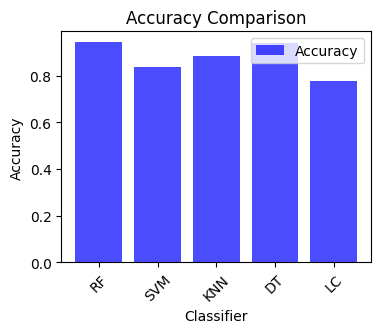

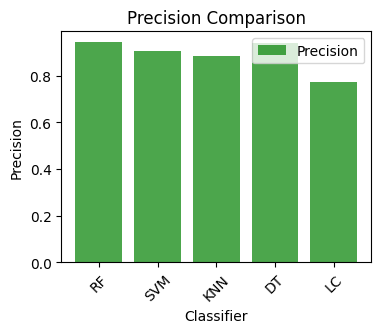

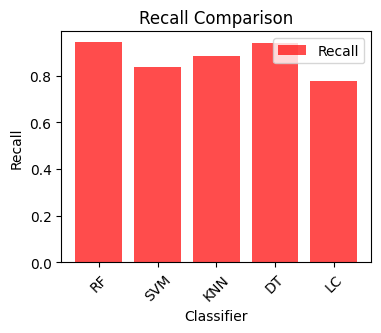

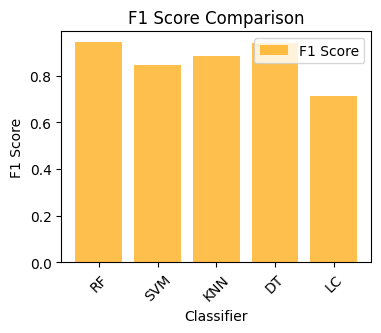

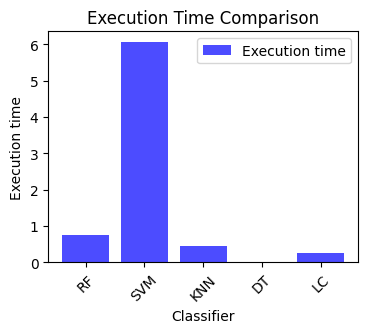

In [105]:
# Initialize classifiers
# classifiers = {
#     'Random Forest': RandomForestClassifier(),
#     'SVM': SVC(kernel='rbf'),
#     'K-Nearest Neighbors': KNeighborsClassifier(),
#     'Decision Tree': DecisionTreeClassifier(), #max_depth=3
#     'Linear Classifier': LogisticRegression()
# }

# Create dictionaries to store evaluation metrics
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}
exec_times = {}

# Initialize a dictionary to store trained classifiers
trained_classifiers = {}

# Train classifiers on the training data and evaluate their performance on the test data
for name, classifier in classifiers.items():
    print(f"\n----------------\nTraining and predicting with {name}...")
    start_time = time.time()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_valid)
    end_time = time.time()
    exec_times[name] = end_time - start_time
    accuracy_scores[name] = accuracy_score(y_valid, y_pred)
    precision_scores[name] = precision_score(y_valid, y_pred, average='weighted')
    recall_scores[name] = recall_score(y_valid, y_pred, average='weighted')
    f1_scores[name] = f1_score(y_valid, y_pred, average='weighted')

    ###
    # Save the trained classifier to a file
    filename = f'{name}_classifier.pkl'
    file_path = f'/content/drive/MyDrive/2024-01- 7072CEM (ML Module)/Project/slice_type_prediction/' + filename
    joblib.dump(classifier, file_path)
    print(f"{name} saved as {filename}")
    print(classification_report(y_valid, y_pred))

    # Store the trained classifier in the dictionary
    trained_classifiers[name] = classifier

# Plot evaluation metrics for each classifier
plt.figure(figsize=(4, 3))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='blue', alpha=0.7, label='Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()

###############################
plt.figure(figsize=(4, 3))
plt.bar(precision_scores.keys(), precision_scores.values(), color='green', alpha=0.7, label='Precision')
plt.xlabel('Classifier')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()

################################
plt.figure(figsize=(4, 3))
plt.bar(recall_scores.keys(), recall_scores.values(), color='red', alpha=0.7, label='Recall')
plt.xlabel('Classifier')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()

################################
plt.figure(figsize=(4, 3))
plt.bar(f1_scores.keys(), f1_scores.values(), color='orange', alpha=0.7, label='F1 Score')
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()

#################################
plt.figure(figsize=(4, 3))
plt.bar(exec_times.keys(), exec_times.values(), color='blue', alpha=0.7, label='Execution time')
plt.xlabel('Classifier')
plt.ylabel('Execution time')
plt.title('Execution Time Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()


----------------
Training and predicting with Random Forest...

----------------
Training and predicting with SVM...

----------------
Training and predicting with K-Nearest Neighbors...

----------------
Training and predicting with Decision Tree...

----------------
Training and predicting with Linear Classifier...


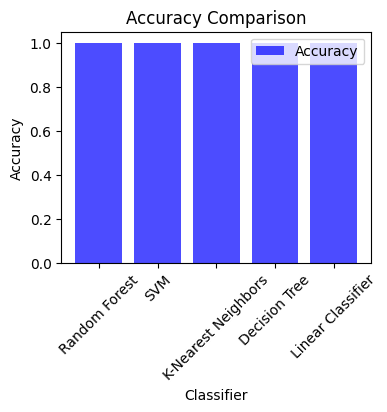

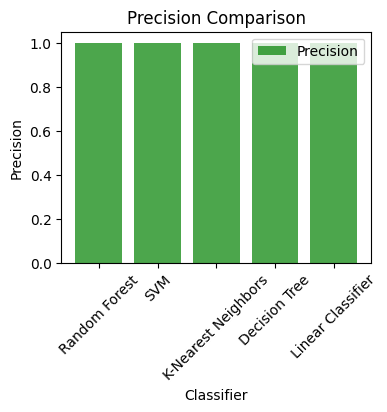

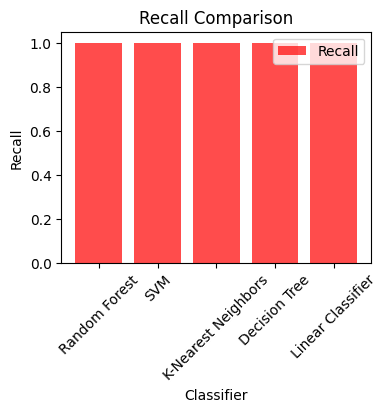

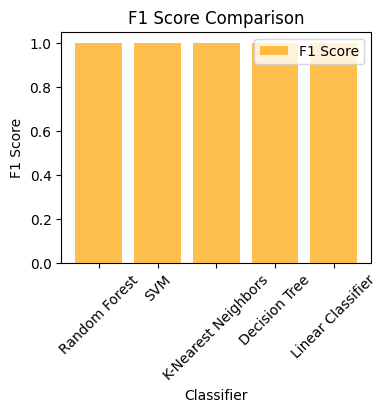

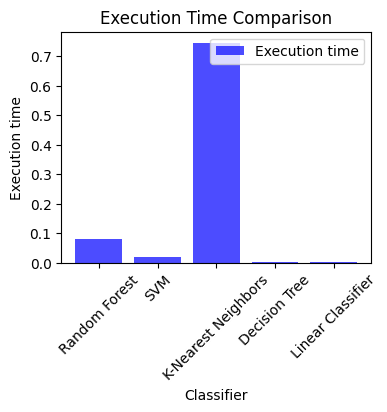

In [ ]:
# Initialize classifiers
# classifiers = {
#     'Random Forest': RandomForestClassifier(),
#     'SVM': SVC(),
#     'K-Nearest Neighbors': KNeighborsClassifier(),
#     'Decision Tree': DecisionTreeClassifier()
# }

# Create dictionaries to store evaluation metrics
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}
exec_times = {}

# Initialize a dictionary to store trained classifiers
#trained_classifiers = {}

# Train classifiers on the training data and evaluate their performance on the test data
for name, classifier in classifiers.items():
    print(f"\n----------------\nTraining and predicting with {name}...")
    start_time = time.time()
    #classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    end_time = time.time()
    exec_times[name] = end_time - start_time
    accuracy_scores[name] = accuracy_score(y_test, y_pred)
    precision_scores[name] = precision_score(y_test, y_pred, average='weighted')
    recall_scores[name] = recall_score(y_test, y_pred, average='weighted')
    f1_scores[name] = f1_score(y_test, y_pred, average='weighted')
    ###
    # Save the trained classifier to a file
    #filename = f'{name}_classifier.pkl'
    #file_path = f'/content/drive/MyDrive/2024-01- 7072CEM (ML Module)/Project/slice_type_prediction/' + filename
    #joblib.dump(classifier, file_path)
    #print(f"{name} saved as {filename}")

    # Store the trained classifier in the dictionary
    #trained_classifiers[name] = classifier

# Plot evaluation metrics for each classifier
plt.figure(figsize=(4, 3))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='blue', alpha=0.7, label='Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()

###############################
plt.figure(figsize=(4, 3))
plt.bar(precision_scores.keys(), precision_scores.values(), color='green', alpha=0.7, label='Precision')
plt.xlabel('Classifier')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()

################################
plt.figure(figsize=(4, 3))
plt.bar(recall_scores.keys(), recall_scores.values(), color='red', alpha=0.7, label='Recall')
plt.xlabel('Classifier')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()

################################
plt.figure(figsize=(4, 3))
plt.bar(f1_scores.keys(), f1_scores.values(), color='orange', alpha=0.7, label='F1 Score')
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()

#################################
plt.figure(figsize=(4, 3))
plt.bar(exec_times.keys(), exec_times.values(), color='blue', alpha=0.7, label='Execution time')
plt.xlabel('Classifier')
plt.ylabel('Execution time')
plt.title('Execution Time Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import sklearn.tree as tr
from sklearn.decomposition import PCA

# Drop the categorical variables from the dataframe
numerical = df.drop(['slice Type', 'Healthcare', 'Industry 4.0', 'IoT Devices', 'Public Safety', 'Smart City & Home', 'Smart Transportation', 'Smartphone'], axis=1)

# Standardize the numerical variables
standardized = (numerical - numerical.mean()) / numerical.std()

# Perform PCA with two components
pca = PCA(n_components=2)
components = pca.fit_transform(standardized)

# Create a scatterplot of the two principal components
plt.scatter(components[:, 0], components[:, 1])
plt.title('PCA Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
# Load the train dataset



# Split the train dataset into features and target variable
# X = df_train_cleaned.drop(columns=['Packet delay','IoT','LTE/5G','Industry 4.0','Smartphone','slice Type'])
#X = df_train_cleaned.drop(columns=['slice Type'])

#y = df_train_cleaned['slice Type']

# Standardize the features
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X)

# Split the dataset into 70% training data and 30% test data
X_train, xx_test, y_train, yy_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(xx_test, yy_test, test_size=0.5, random_state=42) # 25% of data validation, 25% test, 50 % train

print(yy_test.shape)

(12634,)


In [ ]:
# Load the trained classifiers
trained_classifiers = {}
for name in classifiers.keys():
    filename = f'/content/drive/MyDrive/2024-01- 7072CEM (ML Module)/Project/slice_type_prediction/{name}_classifier.pkl'
    trained_classifiers[name] = joblib.load(filename)
    print(f"Loaded {name} from {filename}")

X_test = df_test_cleaned
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test dataset using each classifier
predictions = {}
exec_times = {}

for name, classifier in trained_classifiers.items():
    print(f"Predicting with {name}...")
    start_time = time.time()
    y_pred = classifier.predict(X_test_scaled)
    predictions[name] = y_pred
    end_time = time.time()
    exec_times[name] = end_time - start_time

# Evaluate predictions (qualitatively)
for name, y_pred in predictions.items():
    print(f"Predictions using {name}:")
    print(pd.Series(y_pred).value_counts())
    print("\n")
    print(f"Execution time:")
    print(exec_times[name])
    print("\n------------")



Loaded Random Forest from /content/drive/MyDrive/2024-01- 7072CEM (ML Module)/Project/slice_type_prediction/Random Forest_classifier.pkl
Loaded SVM from /content/drive/MyDrive/2024-01- 7072CEM (ML Module)/Project/slice_type_prediction/SVM_classifier.pkl
Loaded K-Nearest Neighbors from /content/drive/MyDrive/2024-01- 7072CEM (ML Module)/Project/slice_type_prediction/K-Nearest Neighbors_classifier.pkl
Loaded Decision Tree from /content/drive/MyDrive/2024-01- 7072CEM (ML Module)/Project/slice_type_prediction/Decision Tree_classifier.pkl
Predicting with Random Forest...
Predicting with SVM...
Predicting with K-Nearest Neighbors...
Predicting with Decision Tree...
Predictions using Random Forest:
1    16800
3     7392
2     7392
dtype: int64


Execution time:
0.26735925674438477

------------
Predictions using SVM:
1    16800
3     7392
2     7392
dtype: int64


Execution time:
0.07575297355651855

------------
Predictions using K-Nearest Neighbors:
1    16800
3     7392
2     7392
dtype: i

In [ ]:
print(exec_times)

{'Random Forest': 0.4269428253173828, 'SVM': 0.08047771453857422, 'K-Nearest Neighbors': 17.536547899246216, 'Decision Tree': 0.0023450851440429688}
